# **California Housing Price Prediction**
- This notebook demonstrates a complete end to end machine learning project to predict housing prices in California using the California Housing Dataset. The project includes data exploration, data cleaning, feature engineering, complete preprocessing pipelines, cross-validation, model selection, and evaluation.

# **1. Data Loading and Overview**

In [78]:
# === Core ===
import os
import random
import cloudpickle
import math
import numpy as np
import pandas as pd
import warnings

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Configuration ===
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# === Scikit-learn Core ===
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array

# === Models ===
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
    ExtraTreesRegressor, BaggingRegressor, HistGradientBoostingRegressor,
    VotingRegressor, StackingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# === Metrics ===
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Clustering/Custom Transformers ===
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

folder_path = "/content/drive/My Drive/Colab Notebooks/California_House_Price_Prediction"

In [79]:
file_path = f"{folder_path}/dataset/housing.csv"
housing_org = pd.read_csv(file_path)
data = housing_org.copy()
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [81]:
m, n = data.shape
print(f"Number of training examples: {m}")
print(f"Number of Columns: {n}")

Number of training examples: 20640
Number of Columns: 10


In [82]:
display(data.isnull().sum())
print('-' * 50)
null_percent = data.isnull().mean() * 100
null_percent = null_percent[null_percent > 0].sort_values(ascending=False)
print("Percentage of null values per feature:")
print(null_percent.round(2))

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


--------------------------------------------------
Percentage of null values per feature:
total_bedrooms    1.0
dtype: float64


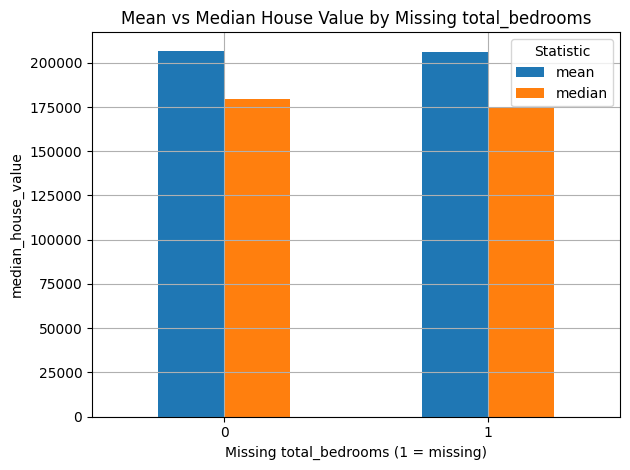

In [83]:
df = data.copy()
df['missing_total_bedrooms'] = np.where(df['total_bedrooms'].isnull(), 1, 0)

# Grouped mean and median
grouped = df.groupby('missing_total_bedrooms')['median_house_value'].agg(['mean', 'median'])

# Plot both side-by-side
grouped.plot(kind='bar', rot=0, grid=True)
plt.xlabel('Missing total_bedrooms (1 = missing)')
plt.ylabel('median_house_value')
plt.title('Mean vs Median House Value by Missing total_bedrooms')
plt.legend(title='Statistic')
plt.tight_layout()
plt.show()

**Missing Values and Dependent variable has some relation.**

In [84]:
def get_summary(data):
    column_names = data.columns
    summary = []

    for col in column_names:
        summary.append([col, data[col].unique(), data[col].nunique(), data[col].isnull().sum(), data[col].dtype])

    summary_df = pd.DataFrame(summary, columns=["Column", "Unique Values", "Unique Count", "Null Value", "data type"])
    print("Shape: ", data.shape)
    display(summary_df)

get_summary(data)

Shape:  (20640, 10)


,Column,Unique Values,Unique Count,Null Value,data type
0,longitude,"[-122.23, -122.22, -122.24, -122.25, -122.26, ...",844,0,float64
1,latitude,"[37.88, 37.86, 37.85, 37.84, 37.83, 37.82, 37....",862,0,float64
2,housing_median_age,"[41.0, 21.0, 52.0, 42.0, 50.0, 40.0, 49.0, 48....",52,0,float64
3,total_rooms,"[880.0, 7099.0, 1467.0, 1274.0, 1627.0, 919.0,...",5926,0,float64
4,total_bedrooms,"[129.0, 1106.0, 190.0, 235.0, 280.0, 213.0, 48...",1923,207,float64
5,population,"[322.0, 2401.0, 496.0, 558.0, 565.0, 413.0, 10...",3888,0,float64
6,households,"[126.0, 1138.0, 177.0, 219.0, 259.0, 193.0, 51...",1815,0,float64
7,median_income,"[8.3252, 8.3014, 7.2574, 5.6431, 3.8462, 4.036...",12928,0,float64
8,median_house_value,"[452600.0, 358500.0, 352100.0, 341300.0, 34220...",3842,0,float64
9,ocean_proximity,"[NEAR BAY, <1H OCEAN, INLAND, NEAR OCEAN, ISLAND]",5,0,object


In [ ]:
data.describe(include='number')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
display(data.describe(include='object'))
data['ocean_proximity'].value_counts()

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [ ]:
# correlation with price, exclude object type
corr_matrix = data.select_dtypes(exclude=['object']).corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688075
total_rooms,0.134153
housing_median_age,0.105623
households,0.065843
total_bedrooms,0.049686
population,-0.024650
longitude,-0.045967
latitude,-0.144160


**median_income is a very important attribute We have to ensure that the test set is representative of the various ranges of incomes.**

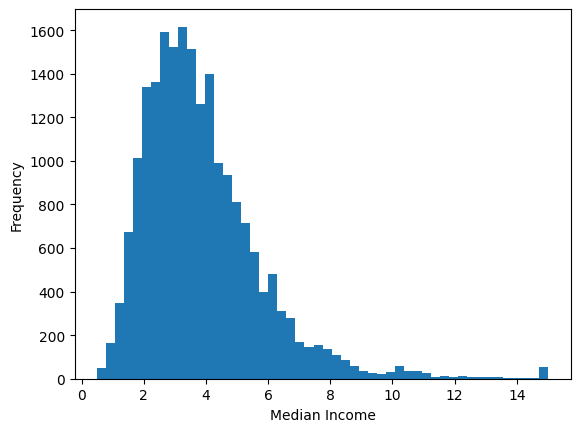

In [ ]:
plt.hist(data['median_income'], bins=50)
plt.xlabel('Median Income')
plt.ylabel('Frequency')
plt.show()

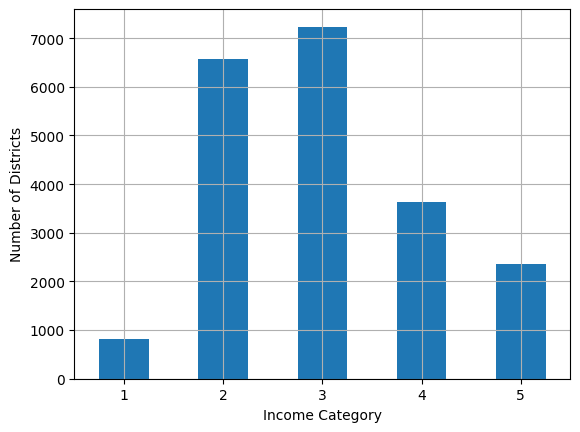

In [ ]:
df = data.copy()
df['income_cat'] = pd.cut(df['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
df['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income Category')
plt.ylabel('Number of Districts')
plt.show()

# **2. Stratified Sampling of data**

In [ ]:
def load_and_split_data():
    file_path = "/content/drive/My Drive/Colab Notebooks/California_House_Price_Prediction/dataset/housing.csv"
    data = pd.read_csv(file_path)

    data['income_cat'] = pd.cut(data['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
    train_set, test_set = train_test_split(data, test_size=0.2,
                                            random_state=42, stratify=data['income_cat'])
    train_set.drop('income_cat', axis=1, inplace=True)
    test_set.drop('income_cat', axis=1, inplace=True)

    # Splitting
    X_train = train_set.drop('median_house_value', axis=1)
    y_train = train_set['median_house_value'].copy()
    X_test = test_set.drop('median_house_value', axis=1)
    y_test = test_set['median_house_value'].copy()

    # Shapes
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_and_split_data()
train_data = X_train.copy()
train_data['median_house_value'] = y_train
housing_labels = y_train.copy()

X_train shape: (16512, 9)
y_train shape: (16512,)
X_test shape: (4128, 9)
y_test shape: (4128,)


# **3. EDA and Feature Engineering**

In [ ]:
train_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY,458300.0
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN,483800.0
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND,101700.0
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND,96100.0
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN,361800.0


## **3.1 Numeric Feature**

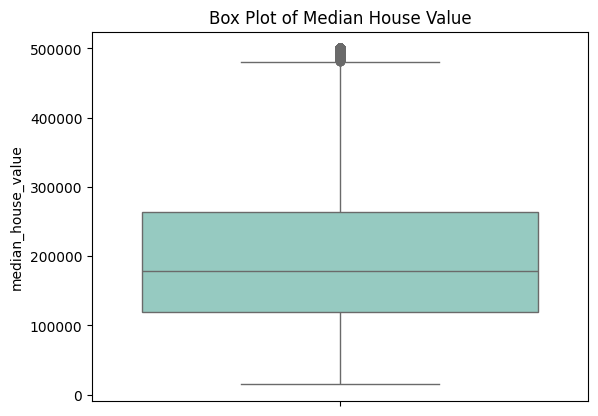

In [ ]:
sns.boxplot(data=train_data, y='median_house_value', palette='Set3')
plt.title('Box Plot of Median House Value')
plt.show()

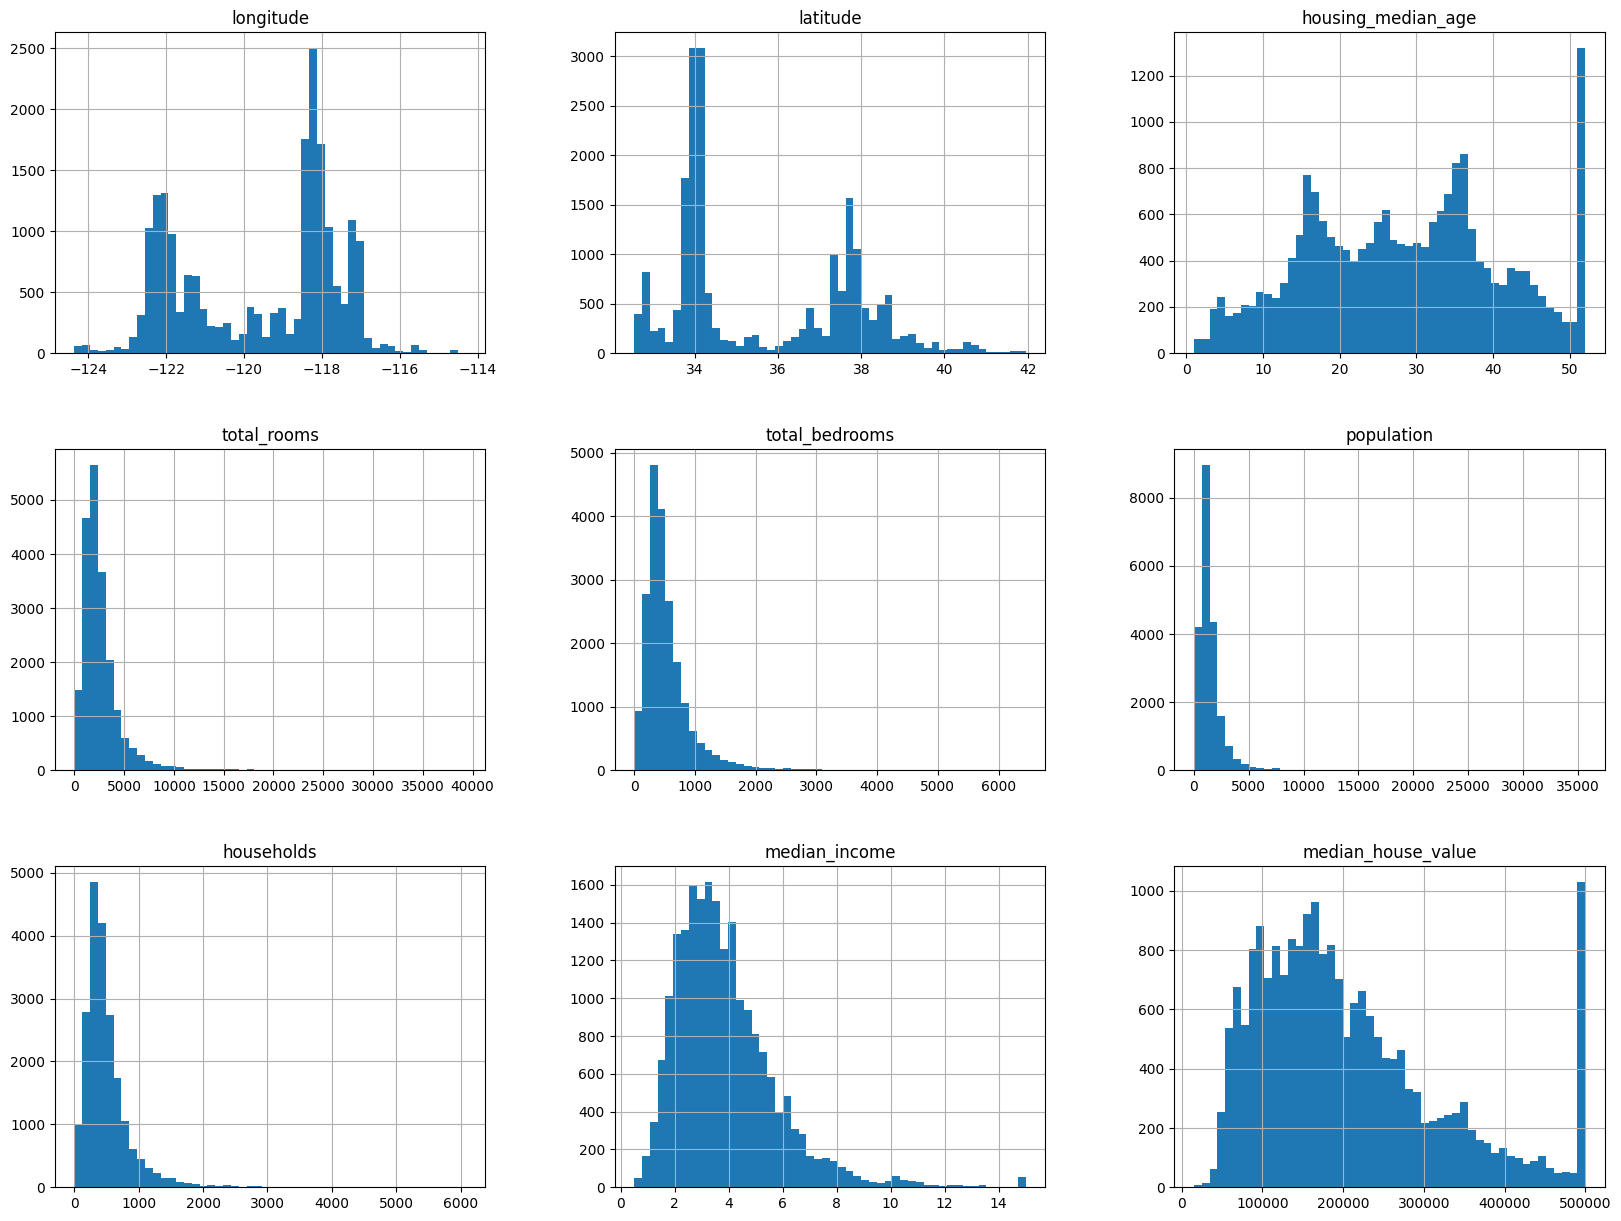

In [ ]:
data.hist(bins=50, figsize=(20,15))
plt.show()

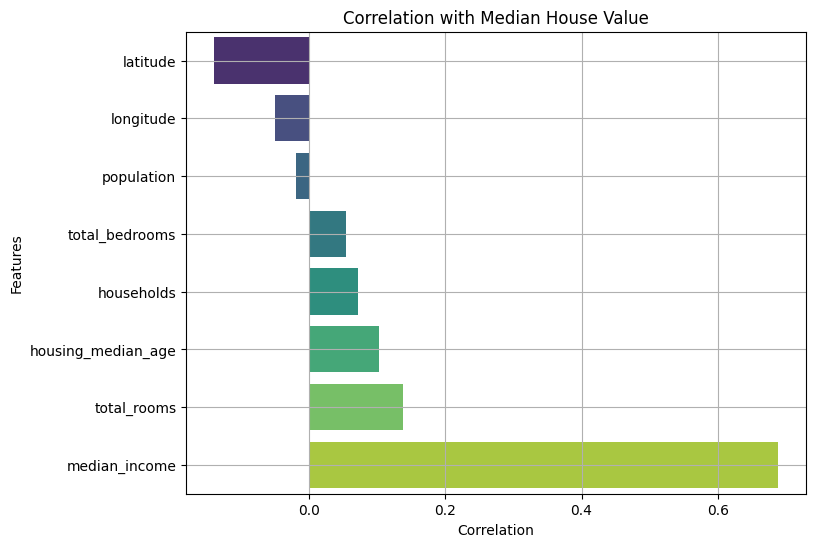

In [ ]:
# Correlation with target
def plot_corr(data):
    corrs = data.corr(numeric_only=True)['median_house_value'].drop('median_house_value').sort_values()

    plt.figure(figsize=(8, 6))
    sns.barplot(x=corrs.values, y=corrs.index, palette='viridis')
    plt.title("Correlation with Median House Value")
    plt.xlabel("Correlation")
    plt.ylabel("Features")
    plt.grid(True)
    plt.show()

plot_corr(train_data)

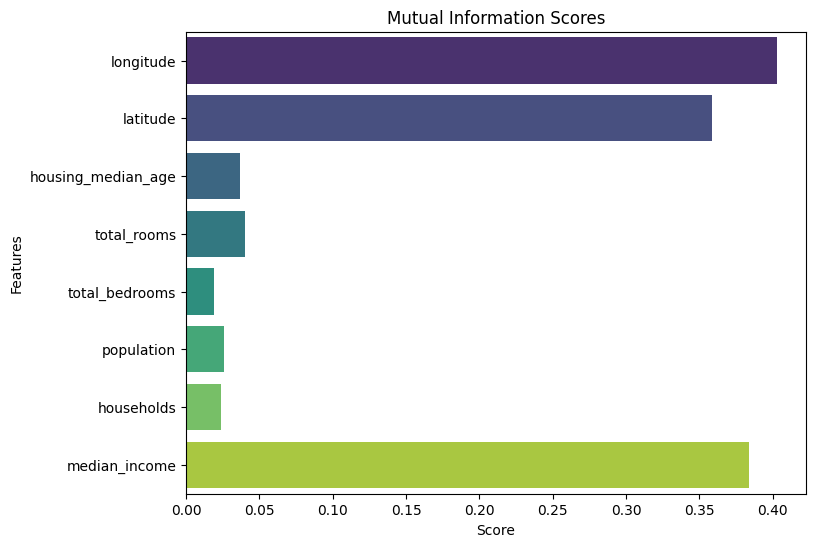

In [ ]:
from sklearn.feature_selection import mutual_info_regression

df = train_data.copy()
df = df.drop(['ocean_proximity'], axis=1)
df.fillna(df.mean(), inplace=True)
mi_scores = mutual_info_regression(df.drop('median_house_value', axis=1), df['median_house_value'])
# plot
plt.figure(figsize=(8, 6))
sns.barplot(x=mi_scores, y=df.drop('median_house_value', axis=1).columns, palette='viridis')
plt.title("Mutual Information Scores")
plt.xlabel("Score")
plt.ylabel("Features")
plt.show()

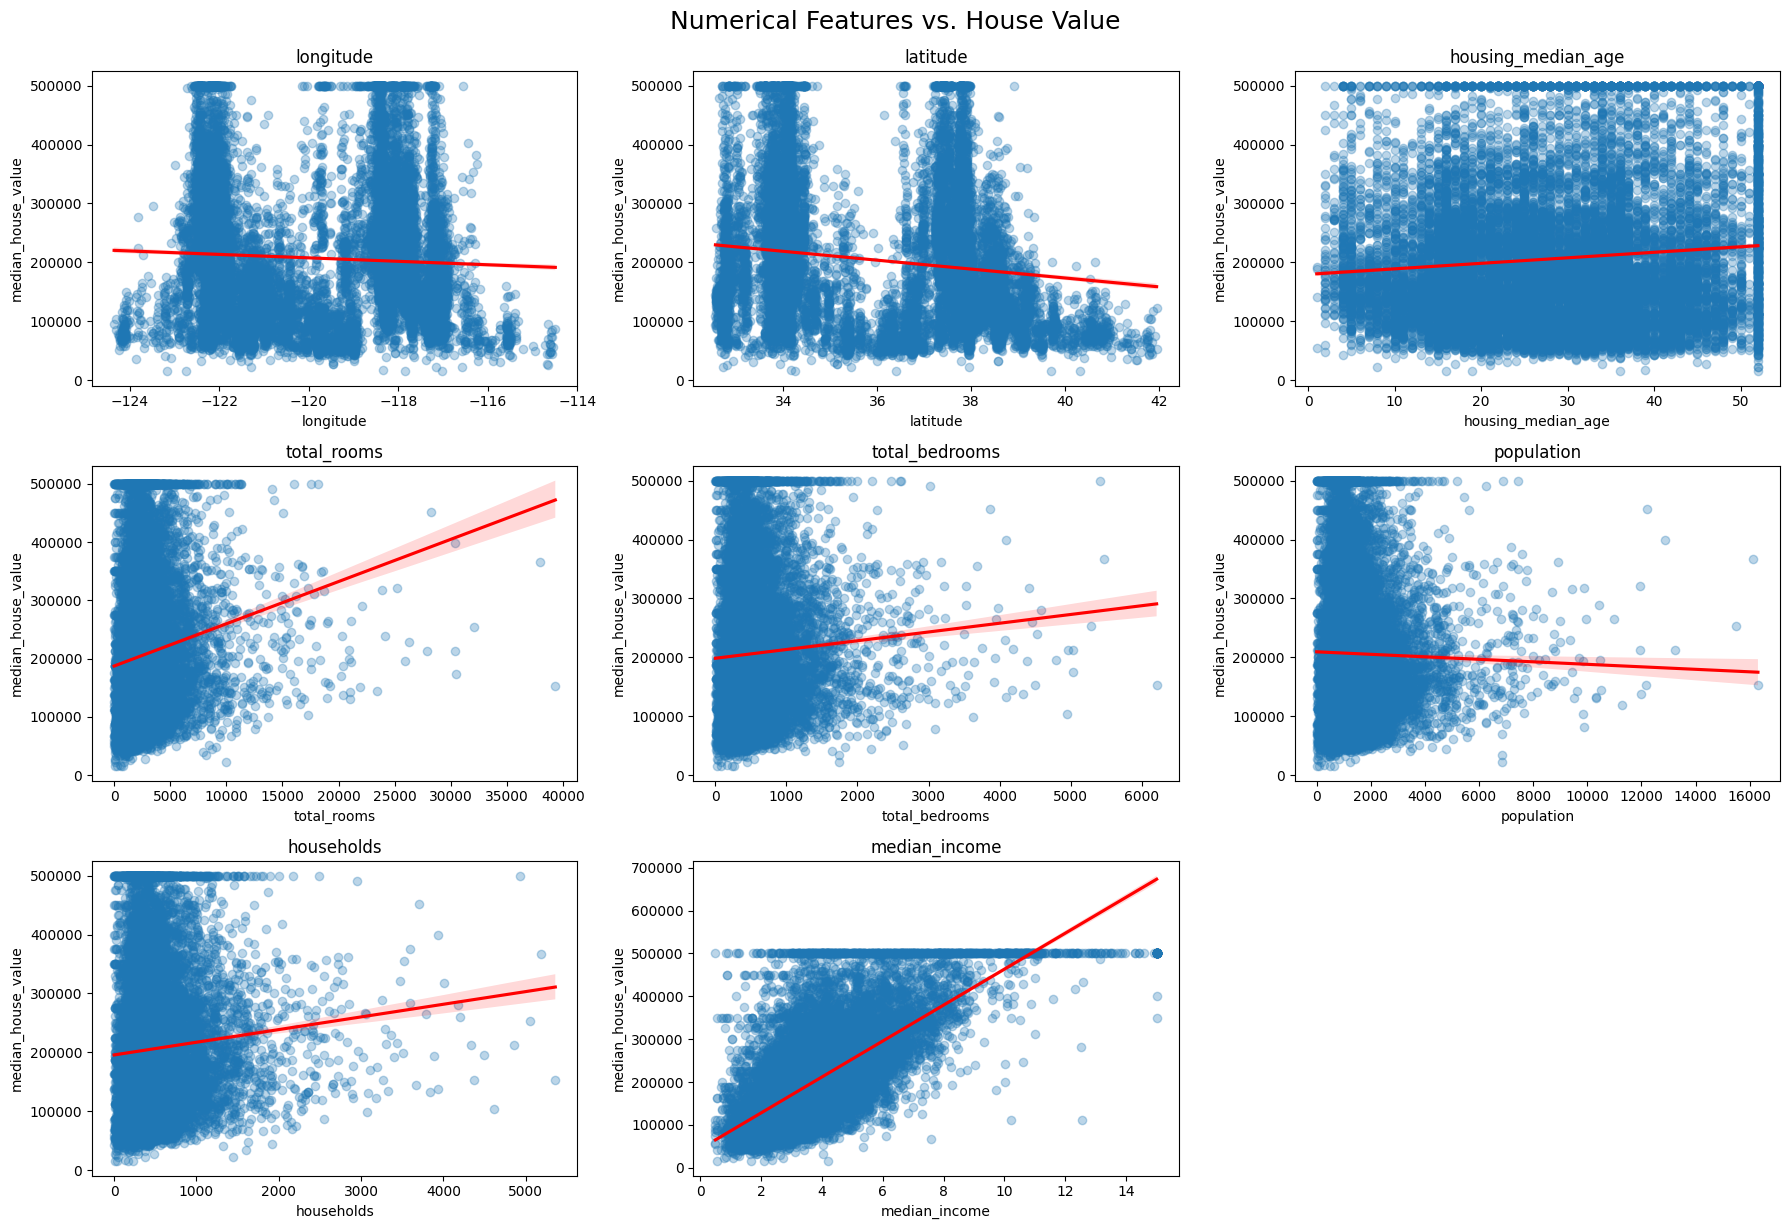

In [ ]:
# One plot per feature: scatter + regression line
numeric_feats = train_data.select_dtypes(include='number').drop(columns=['median_house_value'])

n_cols = 3
n_rows = (len(numeric_feats.columns) + n_cols - 1) // n_cols

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, col in enumerate(numeric_feats.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.regplot(data=train_data, x=col, y='median_house_value', scatter_kws={'alpha':0.3}, line_kws={"color": "red"})
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Numerical Features vs. House Value", fontsize=18, y=1.02)
plt.show()

**After experimenting with different binning strategies, Most effective bin ranges ha've been selected for key features that have less linear correlation with target variable.**

In [ ]:
def plot_binned_features_with_stats(df, feature_bins_dict, target='median_house_value'):
    features = list(feature_bins_dict.items())
    n = len(features)
    cols = 3
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes.flatten()

    for idx, (feature, bins) in enumerate(features):
        # Apply binning
        if isinstance(bins, int):
            df['_bin'] = pd.qcut(df[feature], q=bins, duplicates='drop')
        else:
            df['_bin'] = pd.cut(df[feature], bins=bins, include_lowest=True)

        ax = axes[idx]
        sns.boxplot(data=df, x='_bin', y=target, palette='Set2', ax=ax)
        ax.set_title(f'{feature} (binned) vs. {target}')
        ax.set_xlabel(feature)
        ax.set_ylabel(target)
        ax.tick_params(axis='x', rotation=30)
        ax.grid(True)


        df.drop(columns='_bin', inplace=True)

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])


    plt.tight_layout()
    plt.show()

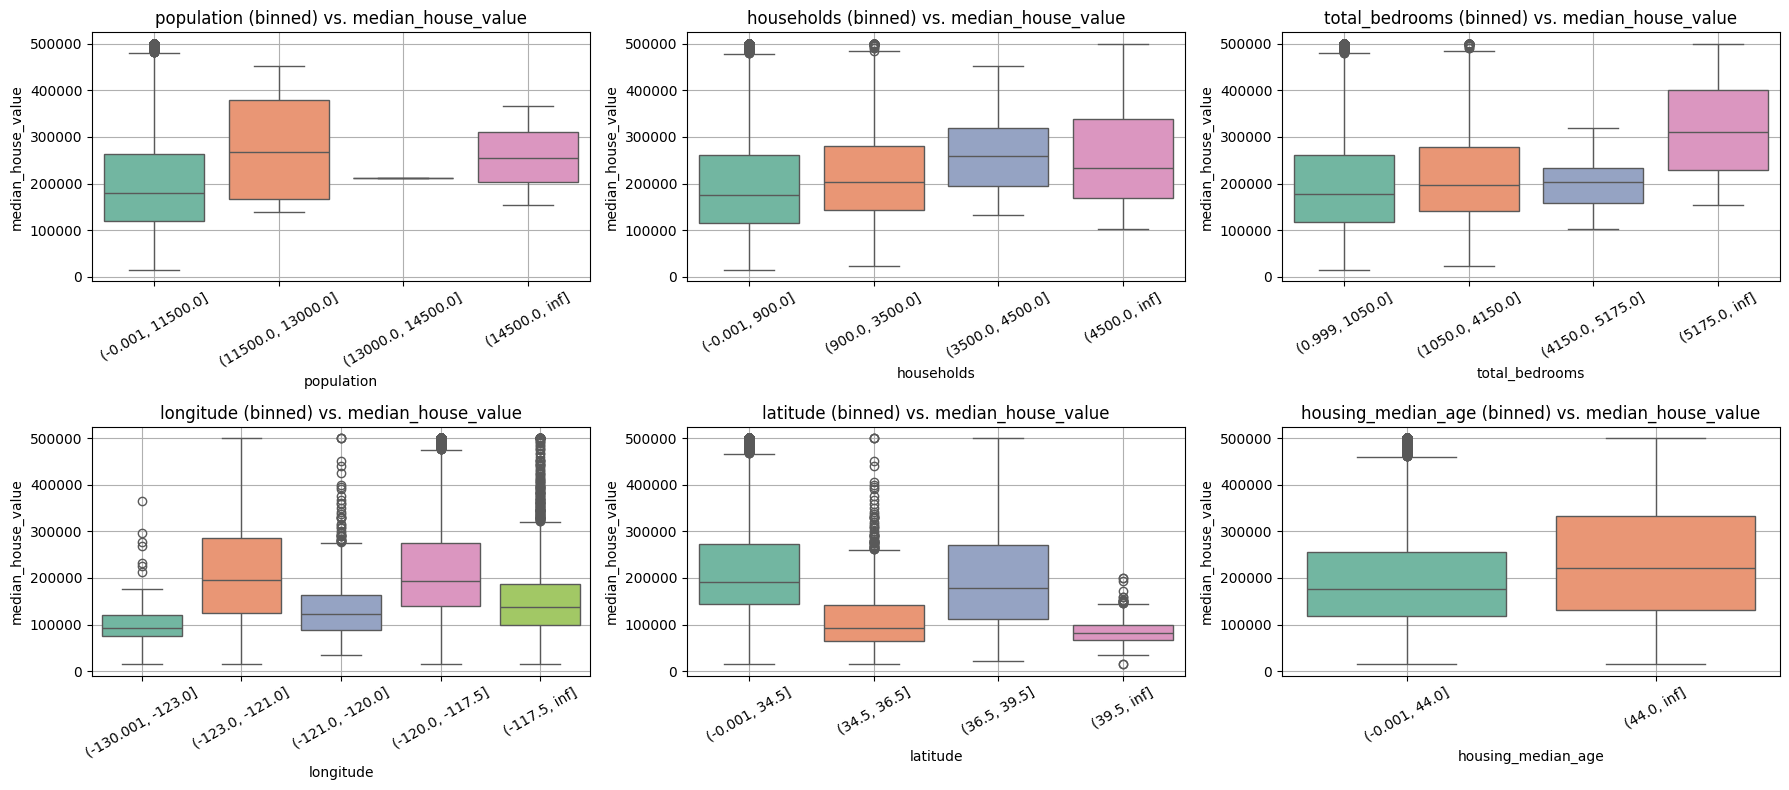

In [ ]:
feature_bins = {
    'population': [0, 11500, 13000, 14500, np.inf],
    'households': [0, 900, 3500, 4500, np.inf],
    'total_bedrooms': [1, 1050, 4150, 5175, np.inf],
    'longitude': [-130, -123, -121, -120, -117.5, np.inf],
    'latitude': [0, 34.5, 36.5, 39.5, np.inf],
    'housing_median_age': [0, 44, np.inf]
}

plot_binned_features_with_stats(train_data, feature_bins)

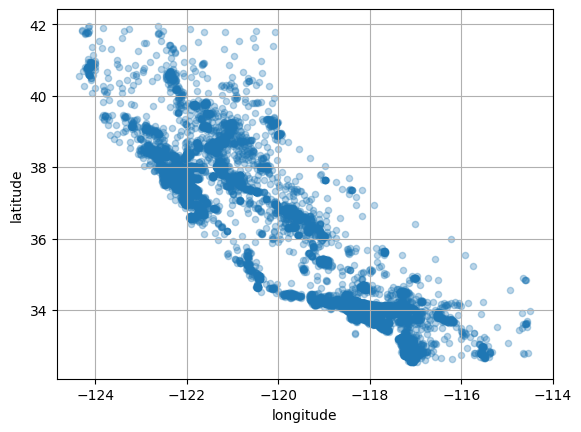

In [ ]:
train_data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.3, grid=True)
plt.show()

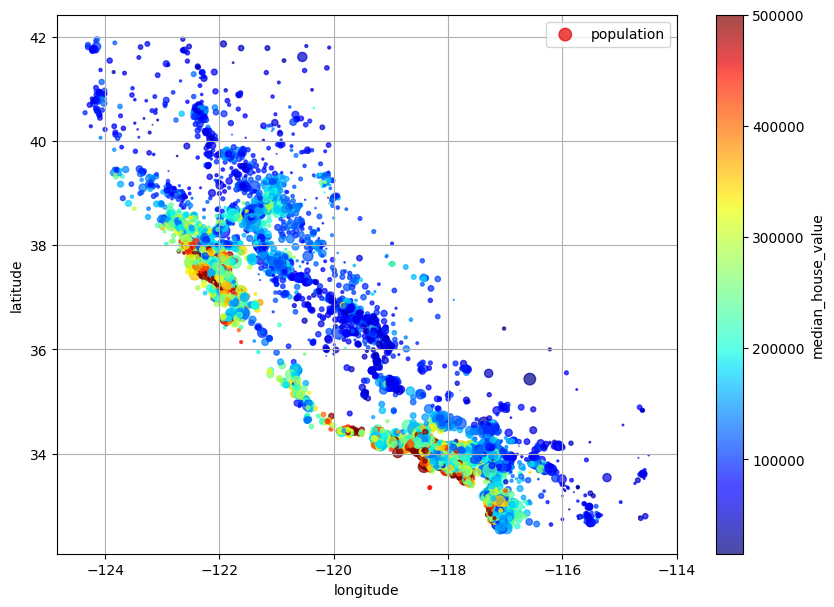

In [ ]:
train_data.plot(kind='scatter', x='longitude', y='latitude', alpha=0.7, grid=True,
             s=train_data['population']/100, label='population', c='median_house_value',
             cmap='jet', colorbar=True, figsize=(10, 7))
plt.show()

The visualization strongly suggests a significant geographical influence on median house values.  
Some of the most densely populated regions also exhibit the highest median house values.  
**Feature Creation:** Create new numerical features where each feature represents the distance to a specific cluster's centroid might help.

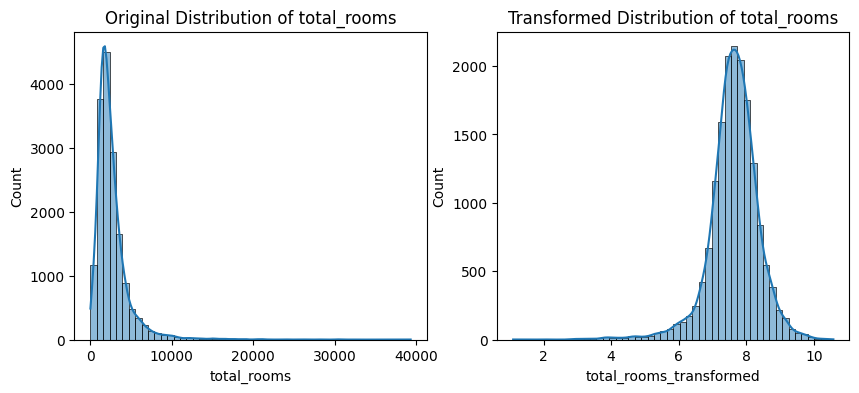

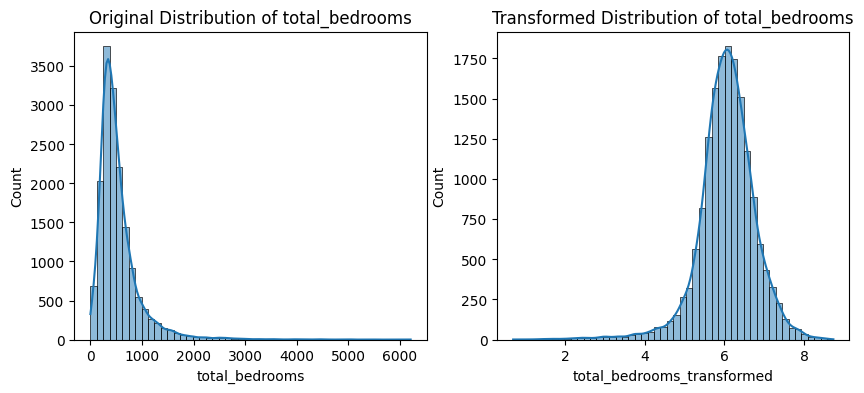

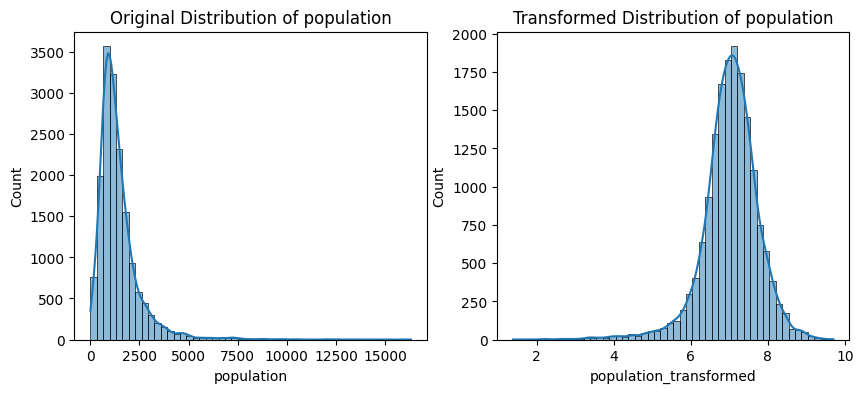

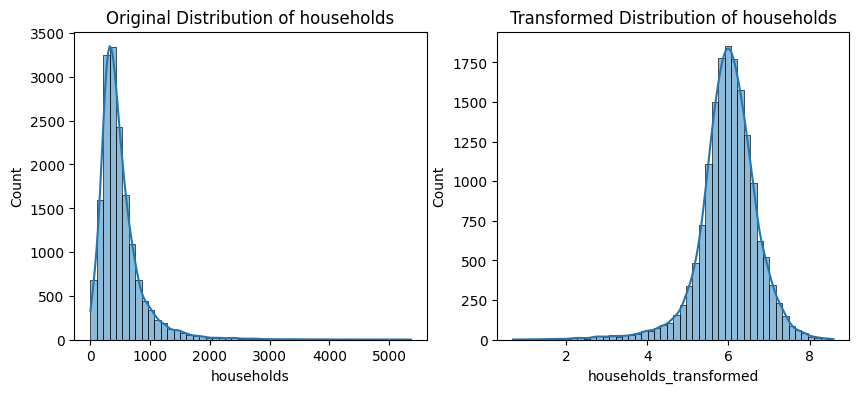

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def apply_transform_and_plot(data, feature, transformer):
    df = data.copy()
    df[feature + "_transformed"] = transformer.transform(df[[feature]])

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    sns.histplot(df[feature], bins=50, kde=True, ax=axes[0])
    axes[0].set_title(f"Original Distribution of {feature}")

    sns.histplot(df[feature + "_transformed"], bins=50, kde=True, ax=axes[1])
    axes[1].set_title(f"Transformed Distribution of {feature}")

    plt.show()


trans = FunctionTransformer(np.log1p)
apply_transform_and_plot(train_data, 'total_rooms', trans)
apply_transform_and_plot(train_data, 'total_bedrooms', trans)
apply_transform_and_plot(train_data, 'population', trans)
apply_transform_and_plot(train_data, 'households', trans)

**Creating New Features**
* 'total_bedrooms', 'total_rooms', 'population', 'households' in the District are not so meaningful for predicting house price. Not showing a good relation.

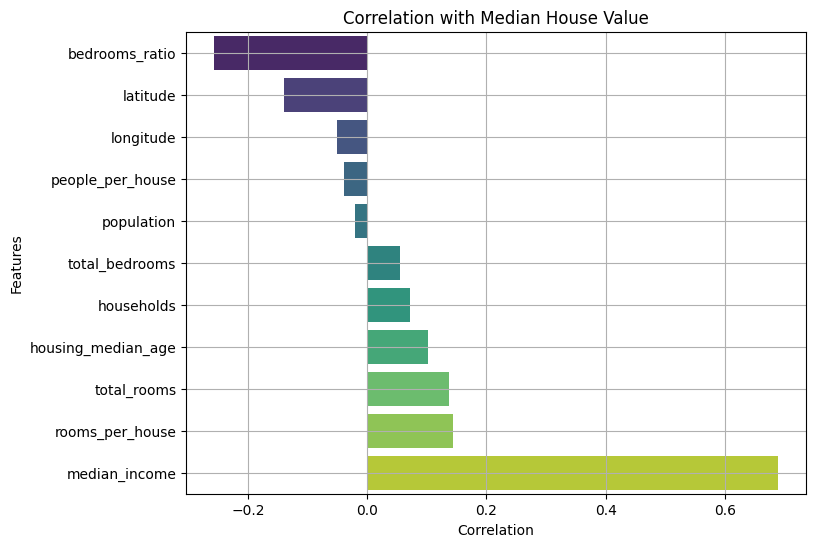

In [ ]:
# Make new usefull features
df = train_data.copy()
df['rooms_per_house'] = df['total_rooms'] / df['households']
df['bedrooms_ratio'] = df['total_bedrooms'] / df['total_rooms']
df['people_per_house'] = df['population'] / df['households']

plot_corr(df)

Features with longer bars would likely be more influential in a linear regression model

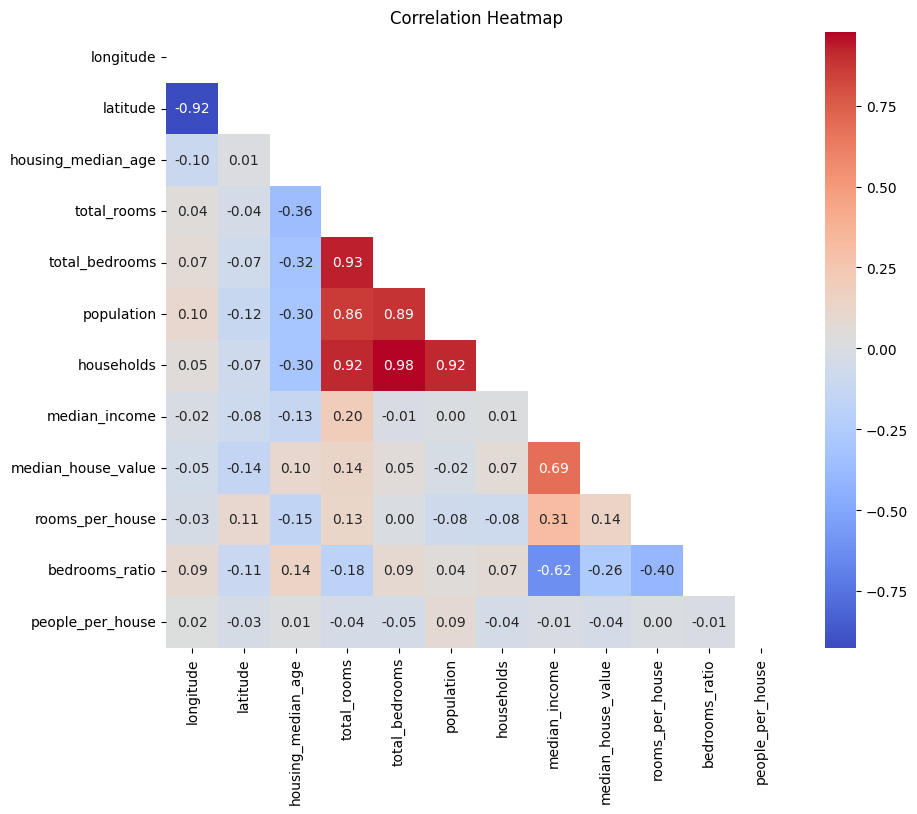

In [ ]:
# Corr Heatmap
plt.figure(figsize=(10, 8))
corr = train_data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))  # Mask upper triangle
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

The very high correlation between population, households, total_bedrooms with total_rooms and population, households, with total_bedrooms and population with households suggests potential multicollinearity. If these features are used in linear models, it might be beneficial to consider using only one of each highly correlated pair or applying dimensionality reduction techniques

## **3.2 Categorical Features**

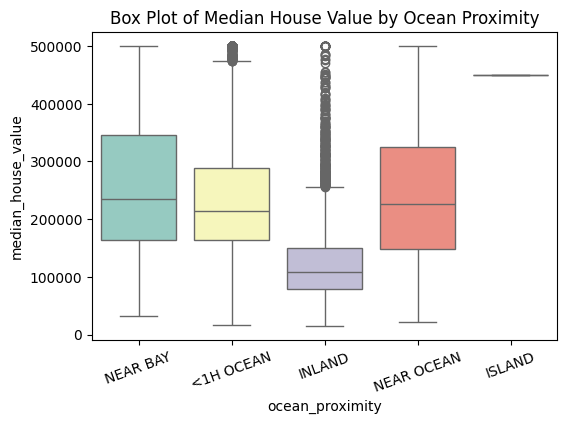

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=train_data, x='ocean_proximity', y='median_house_value', palette='Set3')
plt.xticks(rotation=20)
plt.title('Box Plot of Median House Value by Ocean Proximity')
plt.show()

* ISLAND category have highest prices and there are few houses (5).  
* "NEAR BAY" & "NEAR OCEAN" Are More Expensive.

# **4. Data Preprocessing**

In [ ]:
train_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY,458300.0
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN,483800.0
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND,101700.0
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND,96100.0
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN,361800.0


### **4.1 Ratio Transformer**

In [ ]:
class RatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, numerator_idx=0, denominator_idx=1, prefix=''):
        self.numerator_idx = numerator_idx
        self.denominator_idx = denominator_idx
        self.prefix = prefix

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.astype(float)
        num = StandardScaler().fit_transform(X[:, [self.numerator_idx]])
        denom = StandardScaler().fit_transform(X[:, [self.denominator_idx]])
        ratio = num / denom
        return ratio

    def get_feature_names_out(self, input_features=None):
        return [f"{self.prefix}_ratio"]

def create_ratio_pipeline(numerator_idx, denominator_idx, prefix=''):
    return make_pipeline(
        SimpleImputer(strategy='median'),
        RatioTransformer(numerator_idx, denominator_idx, prefix),
        StandardScaler()
    )

pipe = ColumnTransformer(transformers=[
    ('t', create_ratio_pipeline(0, 1, 'bedrooms'), ['total_bedrooms', 'total_rooms'])
])
data_tr = pipe.fit_transform(train_data)
data_tr_df = pd.DataFrame(data_tr, columns=pipe.get_feature_names_out())
data_tr_df.head()

,t__bedrooms_ratio
0,0.116631
1,0.007618
2,-0.005008
3,-0.005413
4,0.029873


### **4.2 Cluster Similarity**

In [ ]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=0.1, prefix='', sample_weight=None, random_state=42):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.prefix = prefix
        self.random_state = random_state
        self.sample_weight = sample_weight

    def fit(self, X, y=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=self.sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, input_features=None):
        return [f"{self.prefix}_cluster_{i}" for i in range(self.n_clusters)]

def create_cluster_pipeline(n_clusters=10, gamma=0.1, sample_weight=None, random_state=42):
    return make_pipeline(
        SimpleImputer(strategy='median'),
        ClusterSimilarity(n_clusters=n_clusters, gamma=gamma, prefix='geo', sample_weight=sample_weight, random_state=random_state)
    )

pipe = create_cluster_pipeline(n_clusters=10, gamma=0.1, sample_weight=train_data['median_house_value'], random_state=42)
data_tr = pipe.fit_transform(train_data[['latitude', 'longitude']])
data_tr_df = pd.DataFrame(data_tr, columns=pipe.get_feature_names_out())
data_tr_df.head()

,geo_cluster_0,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9
0,0.024492,0.997961,0.187903,0.005183,0.499318,0.411099,0.813610,0.942780,0.046461,0.943698
1,0.957003,0.058095,0.802345,0.722475,0.003331,0.441044,0.072944,0.022888,0.999140,0.110254
2,0.022495,0.958499,0.159576,0.004593,0.629602,0.441234,0.930955,0.947905,0.041624,0.879523
3,0.954678,0.013618,0.454086,0.936197,0.000591,0.219378,0.021678,0.004558,0.852860,0.029577
4,0.986022,0.036391,0.709054,0.824145,0.001693,0.337665,0.045829,0.013320,0.988309,0.073153


## **4.3 RBF Similarity Transformation**

In [ ]:
class RBFSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, reference_values, gamma=0.1, prefix="", postfix=''):
        self.reference_values = reference_values
        self.gamma = gamma
        self.prefix = prefix
        self.postfix = postfix

    def fit(self, X, y=None):
        X = check_array(X)
        return self

    def transform(self, X):
        X = check_array(X)
        return rbf_kernel(X, self.reference_values, gamma=self.gamma)

    def get_feature_names_out(self, input_features=None):
        return [f"{self.prefix}_{val[0]}_{self.postfix}" for val in self.reference_values]

# housing_median_age similarity
def create_simil_pipeline(ref_values, gamma, prefix, postfix):
    return make_pipeline(
        SimpleImputer(strategy='median'),
        RBFSimilarity(reference_values=ref_values, gamma=gamma, prefix=prefix, postfix=postfix),
        StandardScaler()
    )

pipe = create_simil_pipeline(ref_values=[[15], [25], [35]], gamma=0.1, prefix='housing_median_age', postfix='simil')
pipe.fit_transform(train_data[['housing_median_age']])
data_tr = pipe.fit_transform(train_data[['housing_median_age']])
data_tr_df = pd.DataFrame(data_tr, columns=pipe.get_feature_names_out())
data_tr_df.head()

,housing_median_age_15_simil,housing_median_age_25_simil,housing_median_age_35_simil
0,-0.472437,-0.484293,-0.543584
1,-0.472437,-0.484293,-0.289866
2,-0.472437,-0.478497,1.528320
3,1.853607,-0.478497,-0.543584
4,-0.472437,-0.484274,2.253193


## **4.4 Custom Binning Transformer for Feature Engineering**

In [ ]:
class SingleFeatureBinner(BaseEstimator, TransformerMixin):
    def __init__(self, bins, dtype=np.float64, prefix='', postfix=''):
        self.bins = bins
        self.dtype = dtype
        self.prefix = prefix
        self.postfix = postfix

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        X = X.to_numpy()
        col = X[:, 0]
        binned = pd.cut(col, bins=self.bins, labels=False, include_lowest=True)
        # print(f"binned:\n{binned}")

        return np.array(binned.astype(self.dtype)).reshape(-1, 1)


    def get_feature_names_out(self, input_features=None):
        return [f"{self.prefix}_binned{self.postfix}"]



def create_bin_pipeline(bins, prefix, postfix):
    return make_pipeline(
        SingleFeatureBinner(bins, prefix=prefix, postfix=postfix)
    )

bins = [0, 11500, 13000, 14500, np.inf]
pipe = create_bin_pipeline(bins, 'population', '')
data_tr = pipe.fit_transform(train_data[['population']])
data_tr_df = pd.DataFrame(data_tr, columns=pipe.get_feature_names_out())
display(data_tr_df.head())
data_tr_df.value_counts()

,population_binned
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


,count
population_binned,
0.0,16502
1.0,6
3.0,3
2.0,1


# **5. Complete Preprocessing Pipeline**

In [ ]:
def create_num_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler()
    )

def create_log_scale_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(np.log1p, feature_names_out='one-to-one'),
        StandardScaler()
    )

def create_1H_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    )

def create_ratio_pipeline(numerator_idx, denominator_idx, prefix=''):
    return make_pipeline(
        SimpleImputer(strategy='median'),
        RatioTransformer(numerator_idx, denominator_idx, prefix),
        StandardScaler()
    )

def create_cluster_pipeline(n_clusters=10, gamma=0.1, sample_weight=None, random_state=42):
    return make_pipeline(
        SimpleImputer(strategy='median'),
        ClusterSimilarity(n_clusters=n_clusters, gamma=gamma, prefix='geo', sample_weight=sample_weight, random_state=random_state)
    )

def create_simil_pipeline(ref_values, gamma, prefix, postfix):
    return make_pipeline(
        SimpleImputer(strategy='median'),
        RBFSimilarity(reference_values=ref_values, gamma=gamma, prefix=prefix, postfix=postfix),
        StandardScaler()
    )

def create_bin_pipeline(bins, prefix, postfix):
    return make_pipeline(
        SimpleImputer(strategy='median'),
        SingleFeatureBinner(bins, prefix=prefix, postfix=postfix)
    )

In [ ]:
X_train, y_train, X_test, y_test = load_and_split_data()
train_data = X_train.copy()
housing_labels = y_train.copy()

train_data.head()

X_train shape: (16512, 9)
y_train shape: (16512,)
X_test shape: (4128, 9)
y_test shape: (4128,)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN


In [ ]:
num_features = train_data.select_dtypes(include='number').columns.to_list()
cat_features = train_data.select_dtypes(include='object').columns.to_list()

print(f"Numerical Features ({len(num_features)}):\n{num_features}\n")
print(f"Categorical Features ({len(cat_features)}):\n{cat_features}\n")
print(f"All Dataset Features ({train_data.shape[1]}):\n{train_data.columns.to_list()}\n")

Numerical Features (8):
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

Categorical Features (1):
['ocean_proximity']

All Dataset Features (9):
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']



## **5.1 Feature Grouping and Transformation Configuration**

In [ ]:
ratio_features_pairs = {
    'bedrooms': ('total_bedrooms', 'total_rooms'),
    'rooms_per_house': ('total_rooms', 'households'),
    'people_per_house': ('population', 'households')
}

cluster_features = ['latitude', 'longitude']

simil_features = {
    'housing_median_age': [[15], [25], [35]],
    'longitude': [[-122], [-117.5]],
    'latitude': [[34], [37.8]],

}

num_feat = ['longitude', 'latitude', 'housing_median_age']
num_log_feat = ['total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']
cat_feat = ['ocean_proximity']

bin_config = {
    'population': [0, 11500, 13000, 14500, np.inf],
    'households': [0, 900, 3500, 4500, np.inf],
    'total_bedrooms': [1, 1050, 4150, 5175, np.inf],
    'longitude': [-130, -123, -121, -120, -117.5, np.inf],
    'latitude': [0, 34.5, 36.5, 39.5, np.inf],
    'housing_median_age': [0, 44, np.inf],
}

In [ ]:
def complete_preprocessing_pipeline(
    ratio_features_pairs=None,
    cluster_features=None,
    simil_features=None,
    num_feat=None,
    num_log_feat=None,
    cat_feat=None,
    bin_config=None,
    sample_weight=None  # Needed for clustering if using weighted data
):
    transformers = []
    n = 0

    # Ratios
    if ratio_features_pairs:
        for feature, (numerator, denominator) in ratio_features_pairs.items():
            transformers.append((f't{n}', create_ratio_pipeline(0, 1, feature), [numerator, denominator]))
            n += 1

    # Clustering
    if cluster_features:
        transformers.append((f't{n}', create_cluster_pipeline(n_clusters=10, gamma=0.1, sample_weight=sample_weight), cluster_features))
        n += 1

    # Similarity Features
    if simil_features:
        for feature, ref_values in simil_features.items():
            transformers.append((f't{n}', create_simil_pipeline(ref_values, gamma=0.1, prefix=feature, postfix='simil'), [feature]))
            n += 1

    # Scaling Numerical
    if num_feat:
        transformers.append((f't{n}', create_num_pipeline(), num_feat))
        n += 1

    # Log-scaled numerical
    if num_log_feat:
        transformers.append((f't{n}_log', create_log_scale_pipeline(), num_log_feat))
        n += 1

    # Categorical (One-Hot)
    if cat_feat:
        transformers.append((f't{n}', create_1H_pipeline(), cat_feat))
        n += 1

    # Binning
    if bin_config:
        for feature, bins in bin_config.items():
            transformers.append((f't{n}', create_bin_pipeline(bins, prefix=feature, postfix=''), [feature]))
            n += 1

    return ColumnTransformer(transformers)

preprocessing_pipeline = complete_preprocessing_pipeline(
    ratio_features_pairs,
    cluster_features,
    simil_features,
    num_feat,
    num_log_feat,
    cat_feat,
    bin_config
)
preprocessing_pipeline

ColumnTransformer(transformers=[('t0',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('ratiotransformer',
                                                  RatioTransformer(prefix='bedrooms')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['total_bedrooms', 'total_rooms']),
                                ('t1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('ratiotransformer',
                                                  RatioTransformer(prefix...
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('singlefeaturebinner',
                                                  SingleFeatureBinner(bins=[0,
                                                                            34.5,
                                                                            36.5,
                                                                            39.5,
                                                                            inf],
                                                                      prefix='latitude'))]),
                                 ['latitude']),
                                ('t15',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('singlefeaturebinner',
                                                  SingleFeatureBinner(bins=[0,
                                                                            44,
                                                                            inf],
                                                                      prefix='housing_median_age'))]),
                                 ['housing_median_age'])])

In [ ]:
preprocessing_pipeline.fit(X_train)
X_train_prepared = preprocessing_pipeline.transform(X_train)
X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=preprocessing_pipeline.get_feature_names_out())
print(X_train_prepared_df.shape)
X_train_prepared_df.head()

(16512, 39)


,t0__bedrooms_ratio,t1__rooms_per_house_ratio,t2__people_per_house_ratio,t3__geo_cluster_0,t3__geo_cluster_1,t3__geo_cluster_2,t3__geo_cluster_3,t3__geo_cluster_4,t3__geo_cluster_5,t3__geo_cluster_6,t3__geo_cluster_7,t3__geo_cluster_8,t3__geo_cluster_9,t4__housing_median_age_15_simil,t4__housing_median_age_25_simil,t4__housing_median_age_35_simil,t5__longitude_-122_simil,t5__longitude_-117.5_simil,t6__latitude_34_simil,t6__latitude_37.8_simil,t7__longitude,t7__latitude,t7__housing_median_age,t8_log__total_bedrooms,t8_log__total_rooms,t8_log__population,t8_log__households,t8_log__median_income,t9__ocean_proximity_<1H OCEAN,t9__ocean_proximity_INLAND,t9__ocean_proximity_ISLAND,t9__ocean_proximity_NEAR BAY,t9__ocean_proximity_NEAR OCEAN,t10__population_binned,t11__households_binned,t12__total_bedrooms_binned,t13__longitude_binned,t14__latitude_binned,t15__housing_median_age_binned
0,0.116631,0.007480,-0.002062,0.924919,0.040682,0.778160,0.004504,0.225027,0.428666,0.493045,0.997679,0.172861,0.018122,-0.472437,-0.484293,-0.543584,1.249356,-1.394534,-1.139052,1.300129,-1.423037,1.013606,1.861119,1.331502,0.638538,0.457313,1.317893,-1.078547,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0
1,0.007618,0.008797,0.001353,0.120606,0.995714,0.049397,0.697180,0.724635,0.428335,0.002371,0.051294,0.802189,0.901558,-0.472437,-0.484293,-0.289866,-0.683983,0.798383,0.914513,-0.744707,0.596394,-0.702103,0.907630,-0.255920,-0.064085,-0.713720,-0.144801,1.231761,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
2,-0.005008,0.008998,-0.000279,0.898589,0.036555,0.922907,0.003997,0.186478,0.458535,0.595850,0.969062,0.173755,0.017484,-0.472437,-0.478497,1.528320,1.296672,-1.275216,-1.372301,1.214591,-1.203098,1.276119,0.351428,-0.931729,-0.861510,-0.944405,-0.919687,-0.792464,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
3,-0.005413,0.009089,-0.001236,0.034286,0.877433,0.013961,0.926277,0.377156,0.209070,0.000378,0.011793,0.528902,0.988132,1.853607,-0.478497,-0.543584,-1.167261,0.954140,0.903000,-0.933192,1.231216,-0.884924,-0.919891,0.957413,0.944663,0.671649,0.929933,-0.935308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
4,0.029873,0.007975,-0.001762,0.080122,0.994066,0.030056,0.801395,0.629513,0.326370,0.001184,0.031771,0.693383,0.938122,-0.472437,-0.484274,2.253193,-0.799459,0.885268,0.905572,-0.924438,0.711362,-0.875549,0.589800,1.445870,1.004887,0.720167,1.490342,-0.018667,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,0.0,0.0


In [ ]:
features = preprocessing_pipeline.get_feature_names_out()
print("Total number of features:", len(features))
X_train_prepared_df.isna().sum()

Total number of features: 39


,0
t0__bedrooms_ratio,0
t1__rooms_per_house_ratio,0
t2__people_per_house_ratio,0
t3__geo_cluster_0,0
t3__geo_cluster_1,0
t3__geo_cluster_2,0
t3__geo_cluster_3,0
t3__geo_cluster_4,0
t3__geo_cluster_5,0
t3__geo_cluster_6,0


# **6 Model Training**

In [ ]:
models_with_params = {
    'Ridge Regression': (
        Ridge(),
        {
            'alpha': [0.1, 1, 10, 50, 100],
            'solver': ['auto', 'svd', 'cholesky', 'saga']
        }
    ),
    'Lasso Regression': (
        Lasso(max_iter=10000),
        {
            'alpha': [0.001, 0.01, 0.1, 1, 10],
        }
    ),
    'Decision Tree': (
        DecisionTreeRegressor(random_state=42),
        {
            'max_depth': [10, 20, 50, 100, 125, 150],
            'min_samples_split': [2, 5, 10, 15],
            'min_samples_leaf': [1, 2, 4, 8, 16],
            'max_features': ['sqrt', 'log2', None]
        }
    ),
    'KNN': (
        KNeighborsRegressor(),
        {
            'n_neighbors': [5, 7, 9, 12, 15],
            'weights': ['uniform', 'distance']
        }
    ),
    'Random Forest': (
        RandomForestRegressor(random_state=42),
        {
            'n_estimators': [50, 100, 125, 150, 175, 200],
            'max_depth': [5, 10, 20, 30],
            'min_samples_split': [2, 5, 10, 14],
            'min_samples_leaf': [2, 4, 7, 10, 12],
            'max_features': ['sqrt', 'log2', None]
        }
    ),
    'Gradient Boosting': (
        GradientBoostingRegressor(random_state=42),
        {
            'n_estimators': [50, 100, 150, 175, 200],
            'learning_rate': [0.01, 0.05, 0.1, 0.3],
            'max_depth': [3, 5, 10, 20],
            'min_samples_split': [2, 5, 10, 14],
            'min_samples_leaf': [2, 4, 7, 10, 12],
            'max_features': ['sqrt', 'log2', None]
        }
    ),
    'XGBoost': (
        XGBRegressor(random_state=42, objective='reg:squarederror'),
        {
            'n_estimators': [50, 100, 150, 175, 200, 225],
            'max_depth': [3, 5, 10, 20, 30],
            'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
            'subsample': [0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
            'reg_alpha': [0, 0.1, 1],
            'reg_lambda': [1, 1.5, 2],
        }
    ),
    'AdaBoost': (
        AdaBoostRegressor(random_state=42),
        {
            'n_estimators': [50, 100, 150, 175, 200],
            'learning_rate': [0.2, 0.5, 0.7, 1]
        }
    ),
    'Extra Trees': (
        ExtraTreesRegressor(random_state=42),
        {
            'n_estimators': [50, 100, 150, 175, 200],
            'max_depth': [3, 5, 10, 20],
            'min_samples_split': [2, 5, 10, 14],
            'min_samples_leaf': [2, 4, 7, 10, 12],
            'max_features': ['sqrt', 'log2', None]
        }
    ),
    'Bagging': (
        BaggingRegressor(random_state=42),
        {
            'n_estimators': [50, 100, 150, 200],
            'max_samples': [0.5, 0.7, 1.0],
            'max_features': [0.5, 0.7, 1.0]
        }
    ),
    'Hist Gradient Boosting': (
        HistGradientBoostingRegressor(random_state=42),
        {
            'learning_rate': [0.01, 0.05, 0.1],
            'max_iter': [100, 200, 300],
            'max_leaf_nodes': [31, 63, 127],
            'min_samples_leaf': [20, 30, 50]
        }
    )
}

In [ ]:
def evaluate_models_regression(models_with_params, X_train, y_train, n_iter_search=5):
    seed = 42
    np.random.seed(seed)
    random.seed(seed)

    model_metrics = {}  # Dictionary to store metrics for all models
    sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    # Scoring metrics for evaluation (regression metrics)
    scoring_metrics = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

    for model_name, (model, param_grid) in models_with_params.items():
        print(f"Evaluating {model_name}...")

        try:
            # Perform RandomizedSearchCV to tune hyperparameters
            random_search = RandomizedSearchCV(
                model, param_grid,
                n_iter=n_iter_search,
                cv=sk,
                scoring=scoring_metrics,
                refit='r2',  # refit to R-squared as it is a common measure for regression
                random_state=seed,
                return_train_score=True,
                verbose=1,
                n_jobs=-1
            )
            random_search.fit(X_train, y_train)

            # Extract the best parameters and corresponding metrics
            best_index = random_search.best_index_
            best_params = random_search.cv_results_['params'][best_index]

            train_r2 = random_search.cv_results_['mean_train_r2'][best_index]
            cv_r2 = random_search.cv_results_['mean_test_r2'][best_index]
            train_mse = random_search.cv_results_['mean_train_neg_mean_squared_error'][best_index]
            cv_mse = random_search.cv_results_['mean_test_neg_mean_squared_error'][best_index]
            train_mae = random_search.cv_results_['mean_train_neg_mean_absolute_error'][best_index]
            cv_mae = random_search.cv_results_['mean_test_neg_mean_absolute_error'][best_index]

            # Store model evaluation results
            model_metrics[model_name] = {
                'Best Parameters': best_params,
                'Train R2': train_r2.round(2),
                'CV R2': cv_r2.round(2),
                'Train MSE': (-train_mse).round(2),  # Negative MSE is returned by scoring
                'CV MSE': (-cv_mse).round(2),
                'Train MAE': (-train_mae).round(2),  # Negative MAE is returned by scoring
                'CV MAE': (-cv_mae).round(2)
            }

        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")

        print("-" * 50)

    return model_metrics

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
models_metrics = evaluate_models_regression(models_with_params, X_train_prepared, y_train)

Evaluating Ridge Regression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--------------------------------------------------
Evaluating Lasso Regression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--------------------------------------------------
Evaluating Decision Tree...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--------------------------------------------------
Evaluating KNN...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--------------------------------------------------
Evaluating Random Forest...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--------------------------------------------------
Evaluating Gradient Boosting...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--------------------------------------------------
Evaluating XGBoost...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--------------------------------------------------
Evaluating AdaBoost...
Fitting 5 

In [ ]:
def plot_model_metrics_regression(model_metrics):
    # Prepare data for plotting
    model_names = list(model_metrics.keys())
    train_r2_scores = [metrics['Train R2'] for metrics in model_metrics.values()]
    cv_r2_scores = [metrics['CV R2'] for metrics in model_metrics.values()]
    train_mse_scores = [metrics['Train MSE'] for metrics in model_metrics.values()]
    cv_mse_scores = [metrics['CV MSE'] for metrics in model_metrics.values()]
    train_mae_scores = [metrics['Train MAE'] for metrics in model_metrics.values()]
    cv_mae_scores = [metrics['CV MAE'] for metrics in model_metrics.values()]

    fig, ax = plt.subplots(3, 1, figsize=(10, 12))

    # Plot R² Scores
    x = np.arange(len(model_names))
    width = 0.35
    ax[0].bar(x - width / 2, train_r2_scores, width, label="Train R²", color="royalblue")
    ax[0].bar(x + width / 2, cv_r2_scores, width, label="CV R²", color="tomato")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(model_names, rotation=30, ha="right")
    ax[0].set_ylabel("R²")
    ax[0].set_title("Train vs CV R² Score Comparison")
    ax[0].legend()

    # Plot MSE Scores
    ax[1].bar(x - width / 2, train_mse_scores, width, label="Train MSE", color="green")
    ax[1].bar(x + width / 2, cv_mse_scores, width, label="CV MSE", color="orange")
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(model_names, rotation=30, ha="right")
    ax[1].set_ylabel("Mean Squared Error")
    ax[1].set_title("Train vs CV MSE Comparison")
    ax[1].legend()

    # Plot MAE Scores
    ax[2].bar(x - width / 2, train_mae_scores, width, label="Train MAE", color="blue")
    ax[2].bar(x + width / 2, cv_mae_scores, width, label="CV MAE", color="red")
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(model_names, rotation=30, ha="right")
    ax[2].set_ylabel("Mean Absolute Error")
    ax[2].set_title("Train vs CV MAE Comparison")
    ax[2].legend()

    plt.tight_layout()
    plt.show()

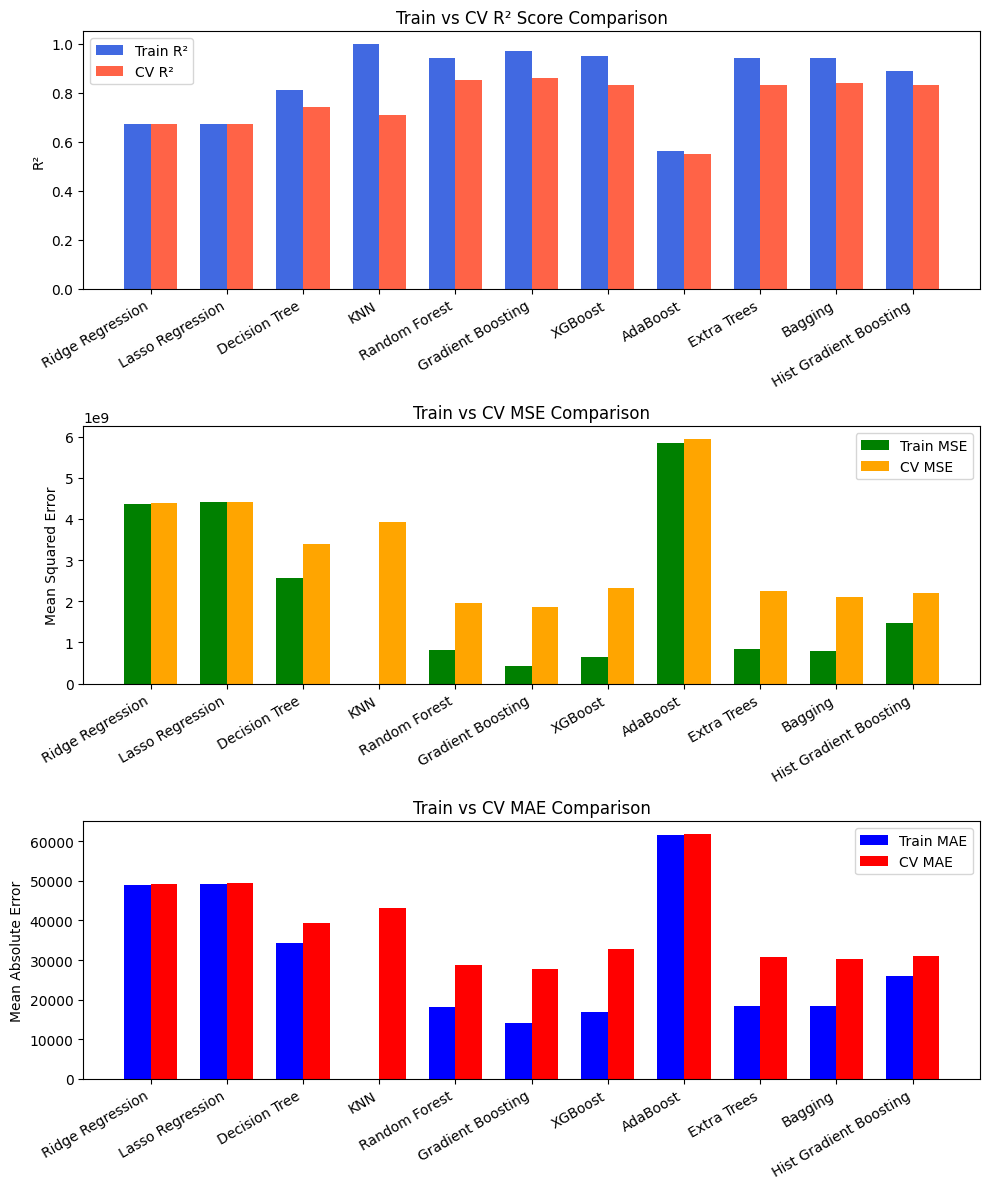

In [ ]:
plot_model_metrics_regression(models_metrics)

In [ ]:
def prepare_metrics_df(metrics_dict):
    df = pd.DataFrame(metrics_dict).T

    # Convert all metric columns except 'Best Parameters' to numeric
    for col in df.columns:
        if col != "Best Parameters":
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Add RMSE columns
    if "Train MSE" in df.columns and "CV MSE" in df.columns:
        df["Train RMSE"] = np.sqrt(df["Train MSE"])
        df["CV RMSE"] = np.sqrt(df["CV MSE"])

    return df

In [ ]:
models_metrics_df = prepare_metrics_df(models_metrics)
models_metrics_df.iloc[:, 1:]

,Train R2,CV R2,Train MSE,CV MSE,Train MAE,CV MAE,Train RMSE,CV RMSE
Ridge Regression,0.67,0.67,4.372388e+09,4.392778e+09,49072.12,49171.93,66124.035117,66278.034838
Lasso Regression,0.67,0.67,4.400169e+09,4.420154e+09,49257.32,49354.00,66333.766413,66484.236112
Decision Tree,0.81,0.74,2.567060e+09,3.392815e+09,34306.98,39271.00,50666.158290,58247.874127
KNN,1.00,0.71,0.000000e+00,3.915213e+09,0.01,43129.93,0.000000,62571.663933
Random Forest,0.94,0.85,8.130398e+08,1.967992e+09,18150.24,28775.20,28513.852579,44362.059556
Gradient Boosting,0.97,0.86,4.341089e+08,1.861486e+09,13972.49,27694.40,20835.280880,43144.940138
XGBoost,0.95,0.83,6.487993e+08,2.321341e+09,16905.72,32765.85,25471.538371,48180.298229
AdaBoost,0.56,0.55,5.854857e+09,5.950683e+09,61631.71,61968.30,76517.037664,77140.670770
Extra Trees,0.94,0.83,8.383062e+08,2.239022e+09,18407.72,30759.17,28953.518773,47318.305320
Bagging,0.94,0.84,7.838570e+08,2.114760e+09,18449.71,30371.19,27997.446398,45986.514459


**Best One: Gradient Boosting Regressor**  
* Train R2: 0.97     <----- highest  
* CV R2: 0.86        <----- highest cross-validated R2  
* CV RMSE: 43144.94  <----- Lowest cross-validated RMSE  

Why it's the best:

* Best overall generalization (highest CV R²).
* Very low bias and manageable variance.
* Smallest errors (lowest RMSE on both train and CV sets).

**Second Best One:  Random Forest Regressor**  
* Train R²: 0.94
* CV R²: 0.85      <---- second-best CV R²
* CV RMSE: 44362.06

In [ ]:
top_models = ["Gradient Boosting", "Random Forest"]
for model in top_models:
    params = models_metrics_df.loc[model, "Best Parameters"]
    print(f"\n Best Parameters for {model}:\n{params}")


 Best Parameters for Gradient Boosting:
{'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'max_depth': 10, 'learning_rate': 0.1}

 Best Parameters for Random Forest:
{'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30}


## 6.1 **Fine-Tuning Best Models**.

### **6.1.1 Gradient Boosting**

In [ ]:
gb_models_with_params = {
    'Gradient Boosting': (
        GradientBoostingRegressor(random_state=42),
        {
            'n_estimators': [125, 150, 175],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [8, 10, 12],
            'min_samples_split': [8, 10, 12],
            'min_samples_leaf': [10, 12, 14],
            'max_features': ['sqrt']
        }
    )
}

gb_model_metrics = evaluate_models_regression(gb_models_with_params, X_train_prepared, y_train)

Evaluating Gradient Boosting...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--------------------------------------------------


In [ ]:
gb_model_metrics_df = prepare_metrics_df(gb_model_metrics)
gb_model_metrics_df.iloc[:, 1:]

,Train R2,CV R2,Train MSE,CV MSE,Train MAE,CV MAE,Train RMSE,CV RMSE
Gradient Boosting,0.98,0.86,2.374317e+08,1.853832e+09,10276.91,27423.2,15408.817722,43056.143749


In [ ]:
# Best Params
gb_best_params = gb_model_metrics_df.loc['Gradient Boosting', 'Best Parameters']
print(gb_best_params)

{'n_estimators': 175, 'min_samples_split': 12, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'max_depth': 12, 'learning_rate': 0.1}


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def cross_validated_metrics(model, X, y, cv=5, n_jobs=-1):
    scoring = {
        'r2': 'r2',
        'rmse': make_scorer(rmse, greater_is_better=False),
        'mae': make_scorer(mean_absolute_error, greater_is_better=False)
    }

    results = cross_validate(
        model, X, y,
        scoring=scoring,
        cv=cv,
        return_train_score=True,
        n_jobs=n_jobs
    )

    metrics_summary = {
        'Train R2': np.mean(results['train_r2']),
        'CV R2': np.mean(results['test_r2']),
        'Train RMSE': -np.mean(results['train_rmse']),
        'CV RMSE': -np.mean(results['test_rmse']),
        'Train MAE': -np.mean(results['train_mae']),
        'CV MAE': -np.mean(results['test_mae']),
    }

    return metrics_summary

In [ ]:
gb_model_tuned = GradientBoostingRegressor(
    n_estimators=155,
    learning_rate=0.08,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=15,
    max_features='sqrt',
)

gb_cv_metrics = cross_validated_metrics(gb_model_tuned, X_train_prepared, y_train)
gb_cv_metrics

{'Train R2': np.float64(0.9339866786424869),
 'CV R2': np.float64(0.855628019151838),
 'Train RMSE': np.float64(29624.75924253955),
 'CV RMSE': np.float64(43797.381777856775),
 'Train MAE': np.float64(19761.18615388838),
 'CV MAE': np.float64(28498.120541226068)}

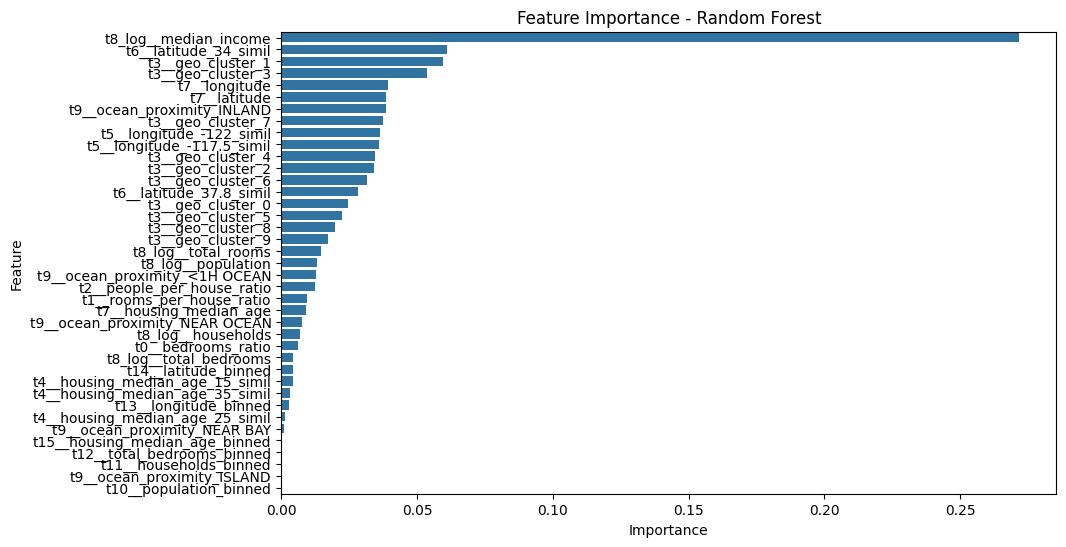

In [ ]:
def feature_imp(model, X_train_prep):
    feat_imp = model.feature_importances_
    feat_df = pd.DataFrame({
        "Feature": X_train_prep.columns,
        "Importance": feat_imp
    })
    feat_df = feat_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)

    feat_df["Cumulative Importance"] = feat_df["Importance"].cumsum()
    # Plot
    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=feat_df)
    plt.title("Feature Importance - Random Forest")
    plt.show()
    return feat_df


gb_model_feat_imp = GradientBoostingRegressor(
    n_estimators=155,
    learning_rate=0.08,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=15,
    max_features='sqrt',
)
gb_model_feat_imp.fit(X_train_prepared_df, y_train)
feat_df = feature_imp(gb_model_feat_imp, X_train_prepared_df)

In [ ]:
feat_df

,Feature,Importance,Cumulative Importance
0,t8_log__median_income,0.271849,0.271849
1,t6__latitude_34_simil,0.061104,0.332953
2,t3__geo_cluster_1,0.059424,0.392377
3,t3__geo_cluster_3,0.053798,0.446175
4,t7__longitude,0.039125,0.485300
5,t7__latitude,0.038726,0.524026
6,t9__ocean_proximity_INLAND,0.038708,0.562734
7,t3__geo_cluster_7,0.037630,0.600365
8,t5__longitude_-122_simil,0.036193,0.636558
9,t5__longitude_-117.5_simil,0.036002,0.672559


In [ ]:
# selected and dropped features names
def get_selected_and_dropped_features(feat_df, thresh=0.90):
    selected_features = feat_df[feat_df["Cumulative Importance"] <= thresh]["Feature"].tolist()

    dropped_features = feat_df[~feat_df["Feature"].isin(selected_features)]["Feature"].tolist()

    print(f"Selected ({len(selected_features)} features):")
    print(selected_features)

    print(f"\nDropped ({len(dropped_features)} features):")
    print(dropped_features)

    return selected_features, dropped_features

In [ ]:
selected_feat, dropped_feat = get_selected_and_dropped_features(feat_df, 0.95)
X_train_prep_reduced = X_train_prepared_df[selected_feat]
X_test_prep_reduced = X_train_prepared_df[selected_feat]

gb_model_reduced = GradientBoostingRegressor(
    n_estimators=170,
    learning_rate=0.08,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=15,
    max_features='sqrt',
)
gb_model_reduced_metrics = cross_validated_metrics(gb_model_reduced, X_train_prep_reduced, y_train)
gb_model_reduced_metrics

Selected (23 features):
['t8_log__median_income', 't6__latitude_34_simil', 't3__geo_cluster_1', 't3__geo_cluster_3', 't7__longitude', 't7__latitude', 't9__ocean_proximity_INLAND', 't3__geo_cluster_7', 't5__longitude_-122_simil', 't5__longitude_-117.5_simil', 't3__geo_cluster_4', 't3__geo_cluster_2', 't3__geo_cluster_6', 't6__latitude_37.8_simil', 't3__geo_cluster_0', 't3__geo_cluster_5', 't3__geo_cluster_8', 't3__geo_cluster_9', 't8_log__total_rooms', 't8_log__population', 't9__ocean_proximity_<1H OCEAN', 't2__people_per_house_ratio', 't1__rooms_per_house_ratio']

Dropped (16 features):
['t7__housing_median_age', 't9__ocean_proximity_NEAR OCEAN', 't8_log__households', 't0__bedrooms_ratio', 't8_log__total_bedrooms', 't14__latitude_binned', 't4__housing_median_age_15_simil', 't4__housing_median_age_35_simil', 't13__longitude_binned', 't4__housing_median_age_25_simil', 't9__ocean_proximity_NEAR BAY', 't15__housing_median_age_binned', 't12__total_bedrooms_binned', 't11__households_binned',

{'Train R2': np.float64(0.9307271243697194),
 'CV R2': np.float64(0.8554170971330926),
 'Train RMSE': np.float64(30347.161801318853),
 'CV RMSE': np.float64(43823.23850266468),
 'Train MAE': np.float64(20124.206497808496),
 'CV MAE': np.float64(28492.95040327558)}

### **6.1.2 Random Forest**

In [ ]:
rf_models_with_params = {
    'Random Forest': (
        RandomForestRegressor(random_state=42),
        {
            'n_estimators': [125, 150, 175],
            'max_depth': [25, 30, 35],
            'min_samples_split': [8, 10, 12],
            'min_samples_leaf': [1, 2, 3],
            'max_features': ['sqrt']
        }
    )
}

rf_model_metrics = evaluate_models_regression(rf_models_with_params, X_train_prepared, y_train)

Evaluating Random Forest...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--------------------------------------------------


In [ ]:
rf_model_metrics_df = prepare_metrics_df(rf_model_metrics)
display(rf_model_metrics_df.iloc[:, 1:])
rf_best_params = rf_model_metrics_df.loc['Random Forest', 'Best Parameters']
print(rf_best_params)

,Train R2,CV R2,Train MSE,CV MSE,Train MAE,CV MAE,Train RMSE,CV RMSE
Random Forest,0.95,0.85,6.013459e+08,1.943015e+09,15826.66,28484.57,24522.354582,44079.649429


{'n_estimators': 125, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25}


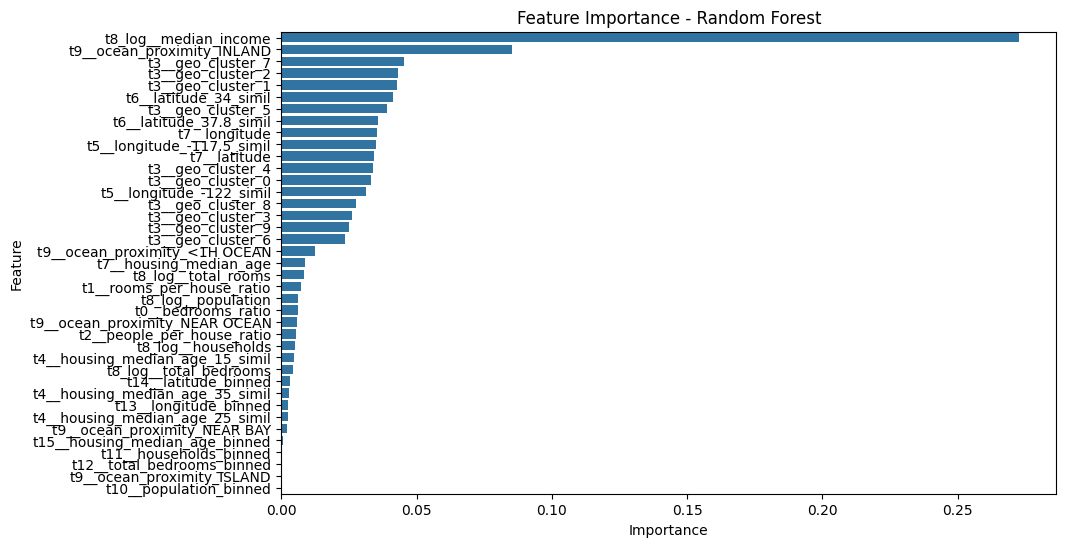

Selected (22 features):
['t8_log__median_income', 't9__ocean_proximity_INLAND', 't3__geo_cluster_7', 't3__geo_cluster_2', 't3__geo_cluster_1', 't6__latitude_34_simil', 't3__geo_cluster_5', 't6__latitude_37.8_simil', 't7__longitude', 't5__longitude_-117.5_simil', 't7__latitude', 't3__geo_cluster_4', 't3__geo_cluster_0', 't5__longitude_-122_simil', 't3__geo_cluster_8', 't3__geo_cluster_3', 't3__geo_cluster_9', 't3__geo_cluster_6', 't9__ocean_proximity_<1H OCEAN', 't7__housing_median_age', 't8_log__total_rooms', 't1__rooms_per_house_ratio']

Dropped (17 features):
['t8_log__population', 't0__bedrooms_ratio', 't9__ocean_proximity_NEAR OCEAN', 't2__people_per_house_ratio', 't8_log__households', 't4__housing_median_age_15_simil', 't8_log__total_bedrooms', 't14__latitude_binned', 't4__housing_median_age_35_simil', 't13__longitude_binned', 't4__housing_median_age_25_simil', 't9__ocean_proximity_NEAR BAY', 't15__housing_median_age_binned', 't11__households_binned', 't12__total_bedrooms_binned',

{'Train R2': np.float64(0.8949562114180086),
 'CV R2': np.float64(0.8433571579401029),
 'Train RMSE': np.float64(37371.6968151977),
 'CV RMSE': np.float64(45618.78631289335),
 'Train MAE': np.float64(24213.37139993561),
 'CV MAE': np.float64(29964.276770461067)}

In [ ]:
rf_model_feat_imp = RandomForestRegressor(
    n_estimators=125,
    max_depth=20,
    min_samples_split=8,
    min_samples_leaf=8,
    max_features='sqrt',
)
rf_model_feat_imp.fit(X_train_prepared_df, y_train)
rf_feat_df = feature_imp(rf_model_feat_imp, X_train_prepared_df)

selected_feat, dropped_feat = get_selected_and_dropped_features(rf_feat_df, 0.95)
X_train_prep_reduced = X_train_prepared_df[selected_feat]
X_test_prep_reduced = X_train_prepared_df[selected_feat]

rf_model_reduced = RandomForestRegressor(
    n_estimators=125,
    max_depth=20,
    min_samples_split=8,
    min_samples_leaf=8,
    max_features='sqrt',
)
rf_model_reduced_metrics = cross_validated_metrics(rf_model_reduced, X_train_prep_reduced, y_train)
rf_model_reduced_metrics

### **6.1.3 VotingRegressor**

In [ ]:
m1 = RandomForestRegressor(
    n_estimators=125,
    max_depth=20,
    min_samples_split=8,
    min_samples_leaf=8,
    max_features='sqrt',
    random_state=42
)

m2 = GradientBoostingRegressor(
    n_estimators=170,
    learning_rate=0.08,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=15,
    max_features='sqrt',
    random_state=42
)

# Create a Voting Regressor
voting_reg = VotingRegressor(
    estimators=[
        ('random_forest', m1),
        ('gradient_boosting', m2)
    ]
)

features_to_drop = [
    't8_log__population',
    't0__bedrooms_ratio',
    't9__ocean_proximity_NEAR OCEAN',
    't2__people_per_house_ratio',
    't8_log__households',
    't4__housing_median_age_15_simil',
    't8_log__total_bedrooms',
    't14__latitude_binned',
    't4__housing_median_age_35_simil',
    't13__longitude_binned',
    't4__housing_median_age_25_simil',
    't9__ocean_proximity_NEAR BAY',
    't15__housing_median_age_binned',
    't11__households_binned',
    't12__total_bedrooms_binned',
    't9__ocean_proximity_ISLAND',
    't10__population_binned',
    't7__housing_median_age'
]

X_after_drop = X_train_prepared_df.drop(columns=features_to_drop)
voting_metrics = cross_validated_metrics(voting_reg, X_after_drop, y_train)
voting_metrics

{'Train R2': np.float64(0.9108488348308438),
 'CV R2': np.float64(0.8506050761420886),
 'Train RMSE': np.float64(34428.86573596124),
 'CV RMSE': np.float64(44549.42213305271),
 'Train MAE': np.float64(22548.720625613656),
 'CV MAE': np.float64(29138.357991139368)}

### **6.1.4 StakingRegressor**

In [ ]:
# Define final estimator
final_estimator = Ridge(alpha=1.0)

# Create Stacking Regressor
stacking_reg = StackingRegressor(
    estimators=[
        ('random_forest', m1),
        ('gradient_boosting', m2)
    ],
    final_estimator=final_estimator,
    passthrough=False,
    n_jobs=-1
)

# Evaluate with cross-validation (just like you did with voting)
stacking_metrics = cross_validated_metrics(stacking_reg, X_after_drop, y_train)
# Show results
stacking_metrics

{'Train R2': np.float64(0.9171288841572313),
 'CV R2': np.float64(0.8519700296079856),
 'Train RMSE': np.float64(33193.64680583199),
 'CV RMSE': np.float64(44345.23220133762),
 'Train MAE': np.float64(21809.998369677374),
 'CV MAE': np.float64(28922.15298294836)}

**VotingRegressor generalize better**

# **7 Final Model**

In [ ]:
ratio_features_pairs = {
    'bedrooms': ('total_bedrooms', 'total_rooms'),
    'rooms_per_house': ('total_rooms', 'households'),
    'people_per_house': ('population', 'households')
}

cluster_features = ['latitude', 'longitude']

simil_features = {
    'housing_median_age': [[15], [25], [35]],
    'longitude': [[-122], [-117.5]],
    'latitude': [[34], [37.8]],

}

num_feat = ['longitude', 'latitude', 'housing_median_age']
num_log_feat = ['total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']
cat_feat = ['ocean_proximity']

bin_config = {
    'population': [0, 11500, 13000, 14500, np.inf],
    'households': [0, 900, 3500, 4500, np.inf],
    'total_bedrooms': [1, 1050, 4150, 5175, np.inf],
    'longitude': [-130, -123, -121, -120, -117.5, np.inf],
    'latitude': [0, 34.5, 36.5, 39.5, np.inf],
    'housing_median_age': [0, 44, np.inf],
}

In [ ]:
X_train, y_train, X_test, y_test = load_and_split_data()

features_to_drop = [
    't8_log__population',
    't0__bedrooms_ratio',
    't9__ocean_proximity_NEAR OCEAN',
    't2__people_per_house_ratio',
    't8_log__households',
    't4__housing_median_age_15_simil',
    't8_log__total_bedrooms',
    't14__latitude_binned',
    't4__housing_median_age_35_simil',
    't13__longitude_binned',
    't4__housing_median_age_25_simil',
    't9__ocean_proximity_NEAR BAY',
    't15__housing_median_age_binned',
    't11__households_binned',
    't12__total_bedrooms_binned',
    't9__ocean_proximity_ISLAND',
    't10__population_binned',
    't7__housing_median_age'
]

# # Pipeline
preprocessing_pipeline = complete_preprocessing_pipeline(
    ratio_features_pairs,
    cluster_features,
    simil_features,
    num_feat,
    num_log_feat,
    cat_feat,
    bin_config
)
# Pipeline - only preprocessing (no dropping here)
pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline)
])

# Fit-transform the pipeline
X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.transform(X_test)

# Convert to DataFrame
X_train_prepared = pd.DataFrame(X_train_prepared, columns=pipeline.get_feature_names_out())
X_test_prepared = pd.DataFrame(X_test_prepared, columns=pipeline.get_feature_names_out())


# Drop from DataFrames
X_train_prepared = X_train_prepared.drop(columns=[f for f in features_to_drop if f in X_train_prepared.columns])
X_test_prepared = X_test_prepared.drop(columns=[f for f in features_to_drop if f in X_test_prepared.columns])
X_train_prepared.head()

X_train shape: (16512, 9)
y_train shape: (16512,)
X_test shape: (4128, 9)
y_test shape: (4128,)


,t1__rooms_per_house_ratio,t3__geo_cluster_0,t3__geo_cluster_1,t3__geo_cluster_2,t3__geo_cluster_3,t3__geo_cluster_4,t3__geo_cluster_5,t3__geo_cluster_6,t3__geo_cluster_7,t3__geo_cluster_8,t3__geo_cluster_9,t5__longitude_-122_simil,t5__longitude_-117.5_simil,t6__latitude_34_simil,t6__latitude_37.8_simil,t7__longitude,t7__latitude,t8_log__total_rooms,t8_log__median_income,t9__ocean_proximity_<1H OCEAN,t9__ocean_proximity_INLAND
0,0.007480,0.924919,0.040682,0.778160,0.004504,0.225027,0.428666,0.493045,0.997679,0.172861,0.018122,1.249356,-1.394534,-1.139052,1.300129,-1.423037,1.013606,0.638538,-1.078547,0.0,0.0
1,0.008797,0.120606,0.995714,0.049397,0.697180,0.724635,0.428335,0.002371,0.051294,0.802189,0.901558,-0.683983,0.798383,0.914513,-0.744707,0.596394,-0.702103,-0.064085,1.231761,1.0,0.0
2,0.008998,0.898589,0.036555,0.922907,0.003997,0.186478,0.458535,0.595850,0.969062,0.173755,0.017484,1.296672,-1.275216,-1.372301,1.214591,-1.203098,1.276119,-0.861510,-0.792464,0.0,1.0
3,0.009089,0.034286,0.877433,0.013961,0.926277,0.377156,0.209070,0.000378,0.011793,0.528902,0.988132,-1.167261,0.954140,0.903000,-0.933192,1.231216,-0.884924,0.944663,-0.935308,0.0,1.0
4,0.007975,0.080122,0.994066,0.030056,0.801395,0.629513,0.326370,0.001184,0.031771,0.693383,0.938122,-0.799459,0.885268,0.905572,-0.924438,0.711362,-0.875549,1.004887,-0.018667,0.0,0.0


**Save Pipeline**

In [ ]:
# Define the path
path = f"{folder_path}/model/"
os.makedirs(folder_path, exist_ok=True)

# Save the preprocessing pipeline
with open(os.path.join(path, 'model_pipeline.pkl'), "wb") as f:
    cloudpickle.dump(pipeline, f)

print(f"Saved successfully at: {path}")

Saved successfully at: /content/drive/My Drive/Colab Notebooks/California_House_Price_Prediction/model/


**Save Data**

In [ ]:
path = f'{folder_path}/dataset/'
# Create directory if it doesn't exist
os.makedirs(path, exist_ok=True)

X_train_prepared.to_csv(f'{path}X_train_prep.csv', index=False)
X_test_prepared.to_csv(f'{path}X_test_prep.csv', index=False)
y_train.to_frame(name='Churn').to_csv(f'{path}y_train.csv', index=False)
y_test.to_frame(name='Churn').to_csv(f'{path}y_test.csv', index=False)
print('Done')

Done


**Model**

In [ ]:
m1 = RandomForestRegressor(
    n_estimators=125,
    max_depth=20,
    min_samples_split=8,
    min_samples_leaf=8,
    max_features='sqrt',
    random_state=42
)

m2 = GradientBoostingRegressor(
    n_estimators=170,
    learning_rate=0.08,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=15,
    max_features='sqrt',
    random_state=42
)

# Create a Voting Regressor
voting_reg = VotingRegressor(
    estimators=[
        ('random_forest', m1),
        ('gradient_boosting', m2)
    ]
)

In [ ]:
# Train
voting_reg.fit(X_train_prepared, y_train)

VotingRegressor(estimators=[('random_forest',
                             RandomForestRegressor(max_depth=20,
                                                   max_features='sqrt',
                                                   min_samples_leaf=8,
                                                   min_samples_split=8,
                                                   n_estimators=125,
                                                   random_state=42)),
                            ('gradient_boosting',
                             GradientBoostingRegressor(learning_rate=0.08,
                                                       max_depth=8,
                                                       max_features='sqrt',
                                                       min_samples_leaf=15,
                                                       min_samples_split=20,
                                                       n_estimators=170,
                                                       random_state=42))])

In [ ]:
# Path to save the model
path = f"{folder_path}/model/"
os.makedirs(path, exist_ok=True)

# Save the trained model
with open(path + 'voting_reg_model.pkl', "wb") as f:
    cloudpickle.dump(voting_reg, f)

print(f"Voting Regressor model saved successfully at: {path}")

Voting Regressor model saved successfully at: /content/drive/MyDrive/Colab Notebooks/California_House_Price_Prediction/model/


**Load and Make Prediction**

In [ ]:
path = f"{folder_path}/model/voting_reg_model.pkl"

# Load the model
with open(path, "rb") as f:
    voting_reg_loaded = cloudpickle.load(f)

print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
path = f'{folder_path}/dataset/'

# Load the datasets
X_train_prepared = pd.read_csv(f'{path}X_train_prep.csv')
X_test_prepared = pd.read_csv(f'{path}X_test_prep.csv')
y_train = pd.read_csv(f'{path}y_train.csv')['Churn']
y_test = pd.read_csv(f'{path}y_test.csv')['Churn']

# Verify the data
print(X_train_prepared.shape)
print(X_test_prepared.shape)
print(y_train.shape)
print(y_test.shape)

(16512, 21)
(4128, 21)
(16512,)
(4128,)


**Performance**

In [ ]:
# Performance on train and test set
train_predictions = voting_reg_loaded.predict(X_train_prepared)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = train_mse ** 0.5
train_r2 = r2_score(y_train, train_predictions)

test_predictions = voting_reg_loaded.predict(X_test_prepared)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = test_mse ** 0.5
test_r2 = r2_score(y_test, test_predictions)

# Make a df
performance_df = pd.DataFrame({
    "Train RMSE": [round(train_rmse, 2)],
    "Train R2": [round(train_r2, 2)],
    "Test RMSE": [round(test_rmse, 2)],
    "Test R2": [round(test_r2, 2)]
})
performance_df

,Train RMSE,Train R2,Test RMSE,Test R2
0,34555.35,0.91,45135.07,0.85


# **8 Prediction**

In [ ]:
# Make a df with actual and pred
sample_X = X_test_prepared[:10]
sample_y_actual = y_test[:10]

sample_y_pred = voting_reg_loaded.predict(sample_X)

comparison_df = pd.DataFrame({
    "Actual": sample_y_actual.values,
    "Predicted": sample_y_pred
})

comparison_df

,Actual,Predicted
0,397700.0,399799.710935
1,202900.0,207332.296054
2,310000.0,379419.992164
3,314300.0,340485.700410
4,187500.0,251111.285404
5,141700.0,174217.234299
6,104900.0,114423.578475
7,275100.0,300791.054858
8,167000.0,185628.108019
9,457700.0,349445.414326
